In [1]:
import pandas as pd
import numpy as np

# Modelo Recurrentes con Embeddings a nivel de caracter

In [2]:
df = pd.read_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [3]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


# Canonical_smiles To secuence

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Utilizando Tokenizer y pad_sequences de keras a nivel de caracter, obtener la entrada tokenizada. Por ejemplo:

**El smiles**:

'C[C@@]12CC[C@H]3[C@]4(C)CCC[C@@]5(C)C(=O)OCC[N+](C)(C)CCCCCCCCC[N+](C)(C)CCOC(=O)[C@]6(C)CCC[C@]7(C)[C@@H]6CC[C@@]68C[C@@H](OC(=O)CCCCCCCCC(=O)O[C@@H]1C[C@@]3(CC[C@@H]45)C2)[C@@](C)(CC[C@@H]76)C8.[Br-].[Br-]'

**Tendría que quedar algo asi (puede que no sea exacto):**

array([ 2, 11,  2, 13, 13, 12,  5,  7,  2,  2, 11,  2, 13, 16, 12, 10, 11,
        2, 13, 12, 15,  3,  2,  4,  2,  2,  2, 11,  2, 13, 13, 12, 23,  3,
        2,  4,  2,  3,  9,  6,  4,  6,  2,  2, 11,  8, 21, 12,  3,  2,  4,
        3,  2,  4,  2,  2,  2,  2,  2,  2,  2,  2,  2, 11,  8, 21, 12,  3,
        2,  4,  3,  2,  4,  2,  2,  6,  2,  3,  9,  6,  4, 11,  2, 13, 12,
       30,  3,  2,  4,  2,  2,  2, 11,  2, 13, 12, 35,  3,  2,  4, 11,  2,
       13, 13, 16, 12, 30,  2,  2, 11,  2, 13, 13, 12, 30, 36,  2, 11,  2,
       13, 13, 16, 12,  3,  6,  2,  3,  9,  6,  4,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  9,  6,  4,  6, 11,  2, 13, 13, 16, 12,  5,  2, 11,
        2, 13, 13, 12, 10,  3,  2,  2, 11,  2, 13, 13, 16, 12, 15, 23,  4,
        2,  7,  4, 11,  2, 13, 13, 12,  3,  2,  4,  3,  2,  2, 11,  2, 13,
       13, 16, 12, 35, 30,  4,  2, 36, 20, 11, 25, 26, 17, 12, 20, 11, 25,
       26, 17, 12], dtype=int32)
       

**Otro ejemplo:**
smiles: 'NC(=O)O'

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 8, 2, 3, 9, 6, 4, 6], dtype=int32)

**Tener en cuenta:**

- Ver cuanta es la máxima longitud para agregar el padding correspondiente
- En el ejemplo se agrego padding a la izquierda

In [5]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()

In [6]:
X = df['canonical_smiles']
y = df['pIC50']

In [7]:
tokenizer = Tokenizer(num_words = None, oov_token='UNK', filters = '', char_level = True, lower = False)

In [8]:
tokenizer.fit_on_texts(X)

In [9]:
sequences = tokenizer.texts_to_sequences(X)

In [10]:
print(X[0])
print(sequences[0])

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
[3, 3, 7, 2, 6, 15, 15, 4, 18, 2, 8, 2, 2, 2, 2, 4, 7, 3, 2, 11, 2, 2, 2, 2, 2, 11, 5, 2, 8, 5, 2, 4, 10, 7, 5, 25, 6]


In [11]:
print(len(X[0]))
print(len(sequences[0]))

37
37


In [12]:
X_seq_pad = pad_sequences(sequences, maxlen = len(X[max_len_idx]), padding = 'pre' )

In [13]:
X_seq_pad[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        3,  3,  7,  2,  6, 15, 15,  4, 18,  2,  8,  2,  2,  2,  2,  4,  7,
        3,  2, 11,  2,  2,  2,  2,  2, 11,  5,  2,  8,  5,  2,  4, 10,  7,
        5, 25,  6], dtype=int32)

In [ ]:
# Implementar tokenización y guardar en X_seq_pad el dataset tokenizado

# Split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_seq_pad, y, test_size=0.2, random_state=42)

In [16]:
len(X_train), len(y_train), len(X_test)

(4082, 4082, 1021)

In [17]:
X_train.shape

(4082, 207)

In [18]:
y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
5098    3.575118
5099    6.130768
5100    6.292430
5101    3.903090
5102    4.000000
Name: pIC50, Length: 5103, dtype: float64

# Network Model

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

In [20]:
# Métrica

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [21]:
# vocab_size = # Completar largo del vocabulario
vocab_size = len(tokenizer.word_index)

In [22]:
vocab_size

39

In [23]:
max_sequence_len = len(X[max_len_idx])

# Armar modelo en keras de LSTM
El de abajo es un ejemplo propuesto pero puede armar otro similar (siempre con LSTM o GRU)

In [24]:
rnn_neurons_1 = 100
rnn_neurons_2 = 50
input_shape = (max_sequence_len, 1)
dropout_p = 0.2

In [25]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length=max_sequence_len))
model.add(LSTM(rnn_neurons_1, return_sequences = True, dropout=dropout_p, recurrent_dropout=dropout_p))
model.add(LSTM(rnn_neurons_2,  dropout=dropout_p, recurrent_dropout=dropout_p))

model.add(Dense(1))


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 207, 64)           2496      
                                                                 
 lstm (LSTM)                 (None, 207, 100)          66000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 98,747
Trainable params: 98,747
Non-trainable params: 0
_________________________________________________________________


In [29]:
mcp = ModelCheckpoint('models_3/best_model_{epoch}', save_best_only=True, save_format="h5")

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])

In [ ]:
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test, y_test), callbacks=[mcp])

Epoch 1/150
32/32 [==============================] - ETA: 0s - loss: 12.9163 - R2: -3.5410INFO:tensorflow:Assets written to: models_3/best_model_1/assets


32/32 [==============================] - 157s 5s/step - loss: 12.9163 - R2: -3.5410 - val_loss: 3.2453 - val_R2: -0.1425
Epoch 2/150
32/32 [==============================] - ETA: 0s - loss: 2.8341 - R2: -0.0296INFO:tensorflow:Assets written to: models_3/best_model_2/assets


INFO:tensorflow:Assets written to: models_3/best_model_2/assets


32/32 [==============================] - 100s 3s/step - loss: 2.8341 - R2: -0.0296 - val_loss: 2.8859 - val_R2: -0.0065
Epoch 3/150
32/32 [==============================] - ETA: 0s - loss: 2.7889 - R2: -0.0126INFO:tensorflow:Assets written to: models_3/best_model_3/assets


INFO:tensorflow:Assets written to: models_3/best_model_3/assets


32/32 [==============================] - 101s 3s/step - loss: 2.7889 - R2: -0.0126 - val_loss: 2.8855 - val_R2: -0.0061
Epoch 4/150
32/32 [==============================] - ETA: 0s - loss: 2.8043 - R2: -0.0122INFO:tensorflow:Assets written to: models_3/best_model_4/assets


INFO:tensorflow:Assets written to: models_3/best_model_4/assets


32/32 [==============================] - 99s 3s/step - loss: 2.8043 - R2: -0.0122 - val_loss: 2.8850 - val_R2: -0.0059
Epoch 5/150
32/32 [==============================] - 92s 3s/step - loss: 2.7905 - R2: -0.0114 - val_loss: 2.8905 - val_R2: -0.0087
Epoch 6/150
32/32 [==============================] - 95s 3s/step - loss: 2.7838 - R2: -0.0090 - val_loss: 2.8939 - val_R2: -0.0101
Epoch 7/150
32/32 [==============================] - ETA: 0s - loss: 2.7881 - R2: -0.0089INFO:tensorflow:Assets written to: models_3/best_model_7/assets


INFO:tensorflow:Assets written to: models_3/best_model_7/assets


32/32 [==============================] - 99s 3s/step - loss: 2.7881 - R2: -0.0089 - val_loss: 2.8815 - val_R2: -0.0046
Epoch 8/150
32/32 [==============================] - 92s 3s/step - loss: 2.7963 - R2: -0.0107 - val_loss: 2.8951 - val_R2: -0.0107
Epoch 9/150
32/32 [==============================] - ETA: 0s - loss: 2.7805 - R2: -0.0035INFO:tensorflow:Assets written to: models_3/best_model_9/assets


INFO:tensorflow:Assets written to: models_3/best_model_9/assets


32/32 [==============================] - 99s 3s/step - loss: 2.7805 - R2: -0.0035 - val_loss: 2.8767 - val_R2: -0.0032
Epoch 10/150
32/32 [==============================] - ETA: 0s - loss: 2.7882 - R2: -0.0094INFO:tensorflow:Assets written to: models_3/best_model_10/assets


INFO:tensorflow:Assets written to: models_3/best_model_10/assets


32/32 [==============================] - 97s 3s/step - loss: 2.7882 - R2: -0.0094 - val_loss: 2.8741 - val_R2: -0.0016
Epoch 11/150
32/32 [==============================] - ETA: 0s - loss: 2.7847 - R2: -0.0090INFO:tensorflow:Assets written to: models_3/best_model_11/assets


INFO:tensorflow:Assets written to: models_3/best_model_11/assets


32/32 [==============================] - 96s 3s/step - loss: 2.7847 - R2: -0.0090 - val_loss: 2.8635 - val_R2: 0.0019
Epoch 12/150
32/32 [==============================] - ETA: 0s - loss: 2.7652 - R2: -4.4465e-05INFO:tensorflow:Assets written to: models_3/best_model_12/assets


INFO:tensorflow:Assets written to: models_3/best_model_12/assets


32/32 [==============================] - 96s 3s/step - loss: 2.7652 - R2: -4.4465e-05 - val_loss: 2.8511 - val_R2: 0.0065
Epoch 13/150
32/32 [==============================] - ETA: 0s - loss: 2.7606 - R2: 0.0013INFO:tensorflow:Assets written to: models_3/best_model_13/assets


INFO:tensorflow:Assets written to: models_3/best_model_13/assets


32/32 [==============================] - 95s 3s/step - loss: 2.7606 - R2: 0.0013 - val_loss: 2.8376 - val_R2: 0.0106
Epoch 14/150
32/32 [==============================] - ETA: 0s - loss: 2.7500 - R2: 0.0053INFO:tensorflow:Assets written to: models_3/best_model_14/assets


INFO:tensorflow:Assets written to: models_3/best_model_14/assets


32/32 [==============================] - 94s 3s/step - loss: 2.7500 - R2: 0.0053 - val_loss: 2.8166 - val_R2: 0.0196
Epoch 15/150
32/32 [==============================] - 88s 3s/step - loss: 2.7381 - R2: 0.0074 - val_loss: 2.8201 - val_R2: 0.0164
Epoch 16/150
32/32 [==============================] - ETA: 0s - loss: 2.7417 - R2: 0.0053INFO:tensorflow:Assets written to: models_3/best_model_16/assets


INFO:tensorflow:Assets written to: models_3/best_model_16/assets


32/32 [==============================] - 95s 3s/step - loss: 2.7417 - R2: 0.0053 - val_loss: 2.8016 - val_R2: 0.0252
Epoch 17/150
32/32 [==============================] - ETA: 0s - loss: 2.7213 - R2: 0.0172INFO:tensorflow:Assets written to: models_3/best_model_17/assets


INFO:tensorflow:Assets written to: models_3/best_model_17/assets


32/32 [==============================] - 95s 3s/step - loss: 2.7213 - R2: 0.0172 - val_loss: 2.7702 - val_R2: 0.0354
Epoch 18/150
32/32 [==============================] - ETA: 0s - loss: 2.7135 - R2: 0.0177INFO:tensorflow:Assets written to: models_3/best_model_18/assets


INFO:tensorflow:Assets written to: models_3/best_model_18/assets


32/32 [==============================] - 94s 3s/step - loss: 2.7135 - R2: 0.0177 - val_loss: 2.7602 - val_R2: 0.0390
Epoch 19/150
32/32 [==============================] - ETA: 0s - loss: 2.7248 - R2: 0.0163INFO:tensorflow:Assets written to: models_3/best_model_19/assets


INFO:tensorflow:Assets written to: models_3/best_model_19/assets


32/32 [==============================] - 94s 3s/step - loss: 2.7248 - R2: 0.0163 - val_loss: 2.7557 - val_R2: 0.0407
Epoch 20/150
32/32 [==============================] - 87s 3s/step - loss: 2.7317 - R2: 0.0143 - val_loss: 2.7576 - val_R2: 0.0398
Epoch 21/150
32/32 [==============================] - 87s 3s/step - loss: 2.7078 - R2: 0.0212 - val_loss: 2.7558 - val_R2: 0.0409
Epoch 22/150
32/32 [==============================] - 88s 3s/step - loss: 2.7033 - R2: 0.0227 - val_loss: 2.7918 - val_R2: 0.0259
Epoch 23/150
32/32 [==============================] - ETA: 0s - loss: 2.7052 - R2: 0.0209INFO:tensorflow:Assets written to: models_3/best_model_23/assets


INFO:tensorflow:Assets written to: models_3/best_model_23/assets


32/32 [==============================] - 94s 3s/step - loss: 2.7052 - R2: 0.0209 - val_loss: 2.7413 - val_R2: 0.0453
Epoch 24/150
32/32 [==============================] - ETA: 0s - loss: 2.7050 - R2: 0.0218INFO:tensorflow:Assets written to: models_3/best_model_24/assets


INFO:tensorflow:Assets written to: models_3/best_model_24/assets


32/32 [==============================] - 93s 3s/step - loss: 2.7050 - R2: 0.0218 - val_loss: 2.7363 - val_R2: 0.0475
Epoch 25/150
32/32 [==============================] - 88s 3s/step - loss: 2.6960 - R2: 0.0212 - val_loss: 2.7562 - val_R2: 0.0388
Epoch 26/150
32/32 [==============================] - ETA: 0s - loss: 2.6903 - R2: 0.0296INFO:tensorflow:Assets written to: models_3/best_model_26/assets


INFO:tensorflow:Assets written to: models_3/best_model_26/assets


32/32 [==============================] - 94s 3s/step - loss: 2.6903 - R2: 0.0296 - val_loss: 2.7085 - val_R2: 0.0569
Epoch 27/150
32/32 [==============================] - ETA: 0s - loss: 2.6691 - R2: 0.0382INFO:tensorflow:Assets written to: models_3/best_model_27/assets


INFO:tensorflow:Assets written to: models_3/best_model_27/assets


32/32 [==============================] - 95s 3s/step - loss: 2.6691 - R2: 0.0382 - val_loss: 2.6633 - val_R2: 0.0722
Epoch 28/150
32/32 [==============================] - 88s 3s/step - loss: 2.6397 - R2: 0.0453 - val_loss: 2.7402 - val_R2: 0.0456
Epoch 29/150
32/32 [==============================] - 87s 3s/step - loss: 2.6790 - R2: 0.0246 - val_loss: 2.6724 - val_R2: 0.0701
Epoch 30/150
32/32 [==============================] - 88s 3s/step - loss: 2.5938 - R2: 0.0618 - val_loss: 2.8579 - val_R2: 0.0046
Epoch 31/150
32/32 [==============================] - ETA: 0s - loss: 2.5623 - R2: 0.0725INFO:tensorflow:Assets written to: models_3/best_model_31/assets


INFO:tensorflow:Assets written to: models_3/best_model_31/assets


32/32 [==============================] - 94s 3s/step - loss: 2.5623 - R2: 0.0725 - val_loss: 2.5798 - val_R2: 0.1011
Epoch 32/150
32/32 [==============================] - ETA: 0s - loss: 2.5062 - R2: 0.0946INFO:tensorflow:Assets written to: models_3/best_model_32/assets


INFO:tensorflow:Assets written to: models_3/best_model_32/assets


32/32 [==============================] - 95s 3s/step - loss: 2.5062 - R2: 0.0946 - val_loss: 2.4859 - val_R2: 0.1353
Epoch 33/150
32/32 [==============================] - ETA: 0s - loss: 2.4425 - R2: 0.1168INFO:tensorflow:Assets written to: models_3/best_model_33/assets


INFO:tensorflow:Assets written to: models_3/best_model_33/assets


32/32 [==============================] - 93s 3s/step - loss: 2.4425 - R2: 0.1168 - val_loss: 2.4640 - val_R2: 0.1424
Epoch 34/150
32/32 [==============================] - ETA: 0s - loss: 2.4262 - R2: 0.1184INFO:tensorflow:Assets written to: models_3/best_model_34/assets


INFO:tensorflow:Assets written to: models_3/best_model_34/assets


32/32 [==============================] - 94s 3s/step - loss: 2.4262 - R2: 0.1184 - val_loss: 2.4292 - val_R2: 0.1559
Epoch 35/150
32/32 [==============================] - ETA: 0s - loss: 2.3572 - R2: 0.1448INFO:tensorflow:Assets written to: models_3/best_model_35/assets


INFO:tensorflow:Assets written to: models_3/best_model_35/assets


32/32 [==============================] - 93s 3s/step - loss: 2.3572 - R2: 0.1448 - val_loss: 2.4225 - val_R2: 0.1576
Epoch 36/150
32/32 [==============================] - ETA: 0s - loss: 2.3395 - R2: 0.1558INFO:tensorflow:Assets written to: models_3/best_model_36/assets


INFO:tensorflow:Assets written to: models_3/best_model_36/assets


32/32 [==============================] - 95s 3s/step - loss: 2.3395 - R2: 0.1558 - val_loss: 2.3718 - val_R2: 0.1765
Epoch 37/150
32/32 [==============================] - ETA: 0s - loss: 2.2716 - R2: 0.1801INFO:tensorflow:Assets written to: models_3/best_model_37/assets


INFO:tensorflow:Assets written to: models_3/best_model_37/assets


32/32 [==============================] - 93s 3s/step - loss: 2.2716 - R2: 0.1801 - val_loss: 2.3602 - val_R2: 0.1793
Epoch 38/150
32/32 [==============================] - ETA: 0s - loss: 2.2806 - R2: 0.1772INFO:tensorflow:Assets written to: models_3/best_model_38/assets


INFO:tensorflow:Assets written to: models_3/best_model_38/assets


32/32 [==============================] - 94s 3s/step - loss: 2.2806 - R2: 0.1772 - val_loss: 2.3007 - val_R2: 0.2000
Epoch 39/150
32/32 [==============================] - ETA: 0s - loss: 2.2292 - R2: 0.1960INFO:tensorflow:Assets written to: models_3/best_model_39/assets


INFO:tensorflow:Assets written to: models_3/best_model_39/assets


32/32 [==============================] - 94s 3s/step - loss: 2.2292 - R2: 0.1960 - val_loss: 2.2807 - val_R2: 0.2066
Epoch 40/150
32/32 [==============================] - ETA: 0s - loss: 2.1619 - R2: 0.2199INFO:tensorflow:Assets written to: models_3/best_model_40/assets


INFO:tensorflow:Assets written to: models_3/best_model_40/assets


32/32 [==============================] - 94s 3s/step - loss: 2.1619 - R2: 0.2199 - val_loss: 2.2078 - val_R2: 0.2326
Epoch 41/150
32/32 [==============================] - 88s 3s/step - loss: 2.1239 - R2: 0.2362 - val_loss: 2.2854 - val_R2: 0.2015
Epoch 42/150
32/32 [==============================] - ETA: 0s - loss: 2.0638 - R2: 0.2573INFO:tensorflow:Assets written to: models_3/best_model_42/assets


INFO:tensorflow:Assets written to: models_3/best_model_42/assets


32/32 [==============================] - 94s 3s/step - loss: 2.0638 - R2: 0.2573 - val_loss: 2.1371 - val_R2: 0.2574
Epoch 43/150
32/32 [==============================] - ETA: 0s - loss: 2.0965 - R2: 0.2358INFO:tensorflow:Assets written to: models_3/best_model_43/assets


INFO:tensorflow:Assets written to: models_3/best_model_43/assets


32/32 [==============================] - 94s 3s/step - loss: 2.0965 - R2: 0.2358 - val_loss: 2.1233 - val_R2: 0.2632
Epoch 44/150
32/32 [==============================] - ETA: 0s - loss: 1.9994 - R2: 0.2780INFO:tensorflow:Assets written to: models_3/best_model_44/assets


INFO:tensorflow:Assets written to: models_3/best_model_44/assets


32/32 [==============================] - 94s 3s/step - loss: 1.9994 - R2: 0.2780 - val_loss: 2.0905 - val_R2: 0.2742
Epoch 45/150
32/32 [==============================] - 87s 3s/step - loss: 1.9988 - R2: 0.2732 - val_loss: 2.0974 - val_R2: 0.2720
Epoch 46/150
32/32 [==============================] - 87s 3s/step - loss: 1.9656 - R2: 0.2874 - val_loss: 2.1220 - val_R2: 0.2624
Epoch 47/150
32/32 [==============================] - ETA: 0s - loss: 1.9665 - R2: 0.2847INFO:tensorflow:Assets written to: models_3/best_model_47/assets


INFO:tensorflow:Assets written to: models_3/best_model_47/assets


32/32 [==============================] - 95s 3s/step - loss: 1.9665 - R2: 0.2847 - val_loss: 2.0653 - val_R2: 0.2840
Epoch 48/150
32/32 [==============================] - 86s 3s/step - loss: 1.8924 - R2: 0.3142 - val_loss: 2.0973 - val_R2: 0.2712
Epoch 49/150
32/32 [==============================] - ETA: 0s - loss: 1.8755 - R2: 0.3261INFO:tensorflow:Assets written to: models_3/best_model_49/assets


INFO:tensorflow:Assets written to: models_3/best_model_49/assets


32/32 [==============================] - 95s 3s/step - loss: 1.8755 - R2: 0.3261 - val_loss: 1.9568 - val_R2: 0.3219
Epoch 50/150
32/32 [==============================] - 87s 3s/step - loss: 1.8625 - R2: 0.3297 - val_loss: 2.0193 - val_R2: 0.2982
Epoch 51/150
32/32 [==============================] - ETA: 0s - loss: 1.8695 - R2: 0.3239INFO:tensorflow:Assets written to: models_3/best_model_51/assets


INFO:tensorflow:Assets written to: models_3/best_model_51/assets


32/32 [==============================] - 93s 3s/step - loss: 1.8695 - R2: 0.3239 - val_loss: 1.9144 - val_R2: 0.3349
Epoch 52/150
32/32 [==============================] - 85s 3s/step - loss: 1.8216 - R2: 0.3400 - val_loss: 2.2901 - val_R2: 0.1755
Epoch 53/150
32/32 [==============================] - 85s 3s/step - loss: 1.8394 - R2: 0.3312 - val_loss: 1.9215 - val_R2: 0.3350
Epoch 54/150
32/32 [==============================] - 86s 3s/step - loss: 1.7836 - R2: 0.3469 - val_loss: 1.9236 - val_R2: 0.3307
Epoch 55/150
32/32 [==============================] - ETA: 0s - loss: 1.7445 - R2: 0.3544INFO:tensorflow:Assets written to: models_3/best_model_55/assets


INFO:tensorflow:Assets written to: models_3/best_model_55/assets


32/32 [==============================] - 93s 3s/step - loss: 1.7445 - R2: 0.3544 - val_loss: 1.8260 - val_R2: 0.3607
Epoch 56/150
32/32 [==============================] - ETA: 0s - loss: 1.7359 - R2: 0.3660INFO:tensorflow:Assets written to: models_3/best_model_56/assets


INFO:tensorflow:Assets written to: models_3/best_model_56/assets


32/32 [==============================] - 92s 3s/step - loss: 1.7359 - R2: 0.3660 - val_loss: 1.7446 - val_R2: 0.3857
Epoch 57/150
32/32 [==============================] - 85s 3s/step - loss: 1.7252 - R2: 0.3741 - val_loss: 1.9358 - val_R2: 0.3287
Epoch 58/150
32/32 [==============================] - 86s 3s/step - loss: 1.7031 - R2: 0.3789 - val_loss: 1.8605 - val_R2: 0.3490
Epoch 59/150
32/32 [==============================] - 96s 3s/step - loss: 1.6980 - R2: 0.3791 - val_loss: 1.7535 - val_R2: 0.3819
Epoch 60/150
32/32 [==============================] - ETA: 0s - loss: 1.6473 - R2: 0.3984INFO:tensorflow:Assets written to: models_3/best_model_60/assets


INFO:tensorflow:Assets written to: models_3/best_model_60/assets


32/32 [==============================] - 99s 3s/step - loss: 1.6473 - R2: 0.3984 - val_loss: 1.6744 - val_R2: 0.4082
Epoch 61/150
32/32 [==============================] - 91s 3s/step - loss: 1.6293 - R2: 0.4058 - val_loss: 1.7678 - val_R2: 0.3723
Epoch 62/150
32/32 [==============================] - 90s 3s/step - loss: 1.7399 - R2: 0.3611 - val_loss: 1.7671 - val_R2: 0.3768
Epoch 63/150
32/32 [==============================] - 90s 3s/step - loss: 1.6688 - R2: 0.3879 - val_loss: 1.7996 - val_R2: 0.3559
Epoch 64/150
32/32 [==============================] - ETA: 0s - loss: 1.5931 - R2: 0.4174INFO:tensorflow:Assets written to: models_3/best_model_64/assets


INFO:tensorflow:Assets written to: models_3/best_model_64/assets


32/32 [==============================] - 103s 3s/step - loss: 1.5931 - R2: 0.4174 - val_loss: 1.6473 - val_R2: 0.4161
Epoch 65/150
32/32 [==============================] - ETA: 0s - loss: 1.5622 - R2: 0.4283INFO:tensorflow:Assets written to: models_3/best_model_65/assets


INFO:tensorflow:Assets written to: models_3/best_model_65/assets


32/32 [==============================] - 100s 3s/step - loss: 1.5622 - R2: 0.4283 - val_loss: 1.5502 - val_R2: 0.4468
Epoch 66/150
32/32 [==============================] - 94s 3s/step - loss: 1.5606 - R2: 0.4286 - val_loss: 1.5750 - val_R2: 0.4340
Epoch 67/150
32/32 [==============================] - 93s 3s/step - loss: 1.5025 - R2: 0.4480 - val_loss: 1.5659 - val_R2: 0.4442
Epoch 68/150
32/32 [==============================] - 92s 3s/step - loss: 1.4700 - R2: 0.4612 - val_loss: 1.5849 - val_R2: 0.4388
Epoch 69/150
32/32 [==============================] - ETA: 0s - loss: 1.5316 - R2: 0.4397INFO:tensorflow:Assets written to: models_3/best_model_69/assets


INFO:tensorflow:Assets written to: models_3/best_model_69/assets


32/32 [==============================] - 98s 3s/step - loss: 1.5316 - R2: 0.4397 - val_loss: 1.4939 - val_R2: 0.4609
Epoch 70/150
11/32 [=========>....................] - ETA: 58s - loss: 1.5255 - R2: 0.4560 

In [ ]:
y_pred = model.predict(X_test)

# Score

In [ ]:
r2 = 1 - ((y_test.values - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [ ]:
r2
#Dos capas lstm, una de 100 y otra de 50, 150 epochs con lr de 0.001, con una entrada de capa de embeddings, 0.2 de dropout


In [ ]:
r2
#Dos bidirectional + dropout

0.574037072443409

In [ ]:
r2
#Dos capas lstm, una de 100 y otra de 50, 180 epochs con lr de 0.001, con una entrada de capa de embeddings

0.6168082150145935

In [ ]:
r2
#Dos capas lstm, una de 200 y otra de 100, 180 epochs con lr de 0.0001

0.49641044754767494

In [ ]:
r2
#Una capa lstm de 200 con lr 0.0001, 200 epochs

0.4434163336044199

In [ ]:
r2
#dos capas lstm, una de 200 y otra de 100 con lr 0.001

0.37273287021805723

In [ ]:
r2
# 0.4984533246797399
#una sola capa lstm de 200 con lr de 0.001

0.34841912001640674

In [ ]:
model.save('models/embed_100_lstm_50_stacked.h5', )

# Load model (solo si se grabo el modelo)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# model_loaded = load_model('models/embed_64_bi_lstm_100_dense_50_bn.h5', custom_objects={'R2': R2})

In [ ]:
y_pred = model_loaded.predict(X_test)

In [ ]:
r2 = 1 - ((y_test.values - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

¿Hasta que valores de r2 logró?

0.6168082150145935

```
# Esto tiene formato de código
```



# Evaluación

<function matplotlib.pyplot.show>

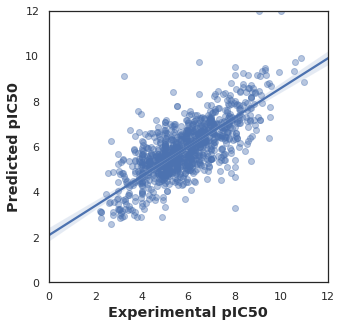

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show